# E-Commerce Chatbot:

# import data form drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import and Load data file

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('/content/drive/MyDrive/intents.json').read()
intents = json.loads(data_file)

## Pre-process data

Here we iterate through the patterns and tokenize the sentence using nltk.word_tokenize() function and append each word in the words list. We also create a list of classes for our tags.

In [ ]:
nltk.download('punkt')
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


lemmatize each word and remove duplicate words from the list

In [ ]:
# lemmatize, lower each word and remove duplicates
nltk.download('wordnet')
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

pickle.dump(words,open('/content/drive/MyDrive/words.pkl','wb'))
pickle.dump(classes,open('/content/drive/MyDrive/classes.pkl','wb'))

265 documents
65 classes ['account_creation', 'account_security', 'bulk_order', 'business_partnership', 'cancel', 'cancel_order', 'chat_support', 'community_feedback', 'company_information', 'confirm', 'delay', 'delivery', 'gift_cards', 'goodbye', 'greeting', 'international_shipping', 'items', 'lost_package', 'loyalty_program', 'loyalty_rewards', 'membership_program', 'mobile app', 'mobile_notifications', 'more', 'multiple_shipments', 'order status', 'order_modification', 'order_tracking', 'payments', 'personal', 'price_match', 'privacy_policy', 'product_availability', 'product_care', 'product_comparisons', 'product_customization', 'product_disposal', 'product_exchanges', 'product_recommendations', 'product_returns', 'product_reviews', 'product_sizes_availability', 'product_usage_tips', 'product_warranty', 'profile info', 'promotions', 'promotions_discounts', 'purchase_assistance', 'reasons', 'refund', 'refund status', 'return', 'shipping_information', 'size_and_fit', 'size_guide', 'so

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Create training and testing data

In [ ]:

training = []
# Create an empty array for our output
output_empty = [0] * len(classes)
# Training set, bag of words for each sentence
for doc in documents:
    # Initialize our bag of words
    bag = []
    # List of tokenized words for the pattern
    pattern_words = doc[0]
    # Lemmatize each word - create base word, in an attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # Create our bag of words array with 1 if the word match is found in the current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # Output is '0' for each tag and '1' for the current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

# Shuffle our features and turn them into np.array
random.shuffle(training)
training = np.array(training)

# Define the ratio for training and validation data
train_ratio = 0.8  # 80% for training, 20% for validation

# Calculate the split index
split_index = int(len(training) * train_ratio)

# Split the data into training and validation sets
train_data = training[:split_index]
validation_data = training[split_index:]

# Create train and validation lists. X - patterns, Y - intents
train_x = list(train_data[:, 0])
train_y = list(train_data[:, 1])

validation_x = list(validation_data[:, 0])
validation_y = list(validation_data[:, 1])

print("Training and validation data created")

Training and validation data created


<ipython-input-21-0069fba0a592>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


## Create Model

In [ ]:
import matplotlib.pyplot as plt

# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons, and 3rd output layer contains number of neurons
# equal to the number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Fitting the model and saving the history
hist = model.fit(
    np.array(train_x), np.array(train_y),
    epochs=200, batch_size=5,
    verbose=1,
    validation_data=(np.array(validation_x), np.array(validation_y))
)

# Save the model
model.save('chatbot_model.h5')

# Print a message indicating that the model is created
print("Model created")

Epoch 1/200
43/43 [==============================] - 1s 7ms/step - loss: 4.1811 - accuracy: 0.0142 - val_loss: 4.1671 - val_accuracy: 0.0189
Epoch 2/200
43/43 [==============================] - 0s 3ms/step - loss: 4.1358 - accuracy: 0.0425 - val_loss: 4.1568 - val_accuracy: 0.0377
Epoch 3/200
43/43 [==============================] - 0s 3ms/step - loss: 4.0584 - accuracy: 0.0708 - val_loss: 4.1476 - val_accuracy: 0.0566
Epoch 4/200
43/43 [==============================] - 0s 3ms/step - loss: 4.0014 - accuracy: 0.0613 - val_loss: 4.1434 - val_accuracy: 0.0377
Epoch 5/200
43/43 [==============================] - 0s 3ms/step - loss: 3.9513 - accuracy: 0.1038 - val_loss: 4.1210 - val_accuracy: 0.0755
Epoch 6/200
43/43 [==============================] - 0s 3ms/step - loss: 3.8226 - accuracy: 0.0896 - val_loss: 4.0718 - val_accuracy: 0.1132
Epoch 7/200
43/43 [==============================] - 0s 3ms/step - loss: 3.7400 - accuracy: 0.1132 - val_loss: 4.0321 - val_accuracy: 0.1321
Epoch 8/200
4

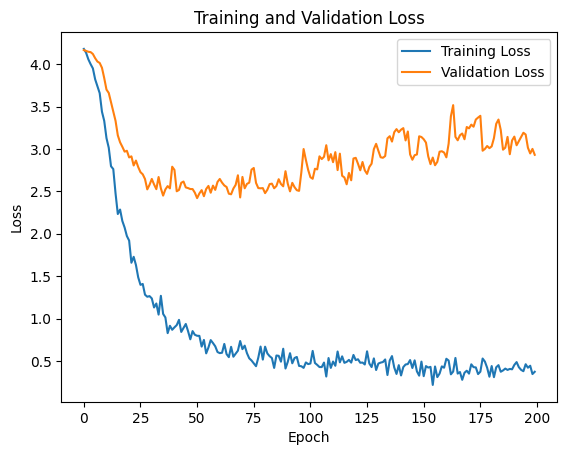

In [ ]:
# Plotting the training and validation loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('/content/drive/MyDrive/intents.json').read())
words = pickle.load(open('/content/drive/MyDrive/words.pkl','rb'))
classes = pickle.load(open('/content/drive/MyDrive/classes.pkl','rb'))

In [ ]:
def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

In [ ]:
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

In [ ]:
def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [ ]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

In [ ]:
def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

## GUI Interface

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def send_message(sender):
    msg = input_box.value
    display_message("You", msg)
    response = chatbot_response(msg)
    display_message("Bot", response)
    input_box.value = ""

def display_message(sender, message):
    message_widget = widgets.HTML(value=f"<b>{sender}:</b> {message}<br>")
    display(message_widget)

# Create input box
input_box = widgets.Text(placeholder='Type a message', description='You:')
input_box.on_submit(send_message)

# Display chat log
chat_log = widgets.Output()
display(chat_log)

# Arrange widgets
widgets.VBox([input_box, chat_log])

Output()

HTML(value='<b>You:</b> hel<br>')

1/1 [==============================] - 0s 67ms/step


HTML(value='<b>Bot:</b> Hello, thanks for visiting. My name is ecom_bot!<br>')

HTML(value='<b>You:</b> hello<br>')

1/1 [==============================] - 0s 22ms/step


HTML(value='<b>Bot:</b> Hey :-) My name is ecom_bot!<br>')

HTML(value='<b>You:</b> i want to buy someth<br>')

1/1 [==============================] - 0s 41ms/step


HTML(value="<b>Bot:</b> You can easily add or change your account details by following the steps below: Step 1…

HTML(value='<b>You:</b> i need same support<br>')

1/1 [==============================] - 0s 87ms/step


HTML(value='<b>Bot:</b> Contact us for further information here: Phone: +212-111-1327. Timings are from 09:00 …

HTML(value='<b>You:</b> can i cancel my order after payment<br>')

1/1 [==============================] - 0s 21ms/step


HTML(value="<b>Bot:</b> Orders can usually be canceled within a specified time frame. Check our order cancella…

HTML(value='<b>You:</b> tell me about you live support<br>')

1/1 [==============================] - 0s 30ms/step


HTML(value='<b>Bot:</b> Yes, we offer live chat support during specified hours. You can initiate a chat with o…

HTML(value='<b>You:</b> tell me about mutlipl shipments?<br>')

1/1 [==============================] - 0s 22ms/step


HTML(value='<b>Bot:</b> Yes, we currently have [X]% off on [specific category/product].<br>')

HTML(value='<b>You:</b> tell me about product care recommandations<br>')

1/1 [==============================] - 0s 20ms/step


HTML(value='<b>Bot:</b> Product care recommendations are usually provided on the product page. Additionally, c…

HTML(value='<b>You:</b> do you offer internationnel shipping<br>')

1/1 [==============================] - 0s 21ms/step


HTML(value='<b>Bot:</b> Yes, we offer international shipping. Shipping rates and delivery times vary by destin…

HTML(value='<b>You:</b> what do you sell<br>')

1/1 [==============================] - 0s 45ms/step


HTML(value="<b>Bot:</b> Search your preference in our flagship store's search bar to see all available product…

HTML(value='<b>You:</b> how can i track my order<br>')

1/1 [==============================] - 0s 39ms/step


HTML(value="<b>Bot:</b> Visit the order page, click on the specific order, select 'track my order', and check …